<a href="https://colab.research.google.com/github/ShovalBenjer/Natural_Language_Proccessing_NLP_Projects/blob/main/MultiOneHotEncoder_Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Author : Shoval Benjer

**Part 1: Text Tokenization**
- Created a smart way to break down book reviews into individual words
- Handles tricky cases like contractions (can't), words with numbers (24k)
- Uses regular expressions to carefully split text into meaningful tokens

**Part 2: Sentiment Analysis with Lexicons**
- Built a basic sentiment detector for book reviews
- Uses pre-defined lists of positive and negative words
- Counts how many positive/negative words appear in each review
- Tries different thresholds to predict if a review is good or bad
- Compares predictions against actual star ratings

**Part 3: Advanced Text Representation**
- Converts text into a special "multi-hot" encoding
- Creates a vector where each word's presence is marked
- Develops a way to measure how "wrong" a prediction is using log loss
- Visualizes how different prediction confidences affect error measurement

**Overall Goal**:
Transform messy text reviews into something a computer can understand and analyze, with the end goal of automatically determining whether a book review is positive or negative.

**Results**

Vocabulary Size: 145

This means after tokenizing all book reviews and filtering for words that appear at least 5 times, we ended up with 145 unique words
Relatively small vocabulary suggests:

Focused domain (book reviews)
Strict frequency filtering
Potentially more advanced tokenization could expand this

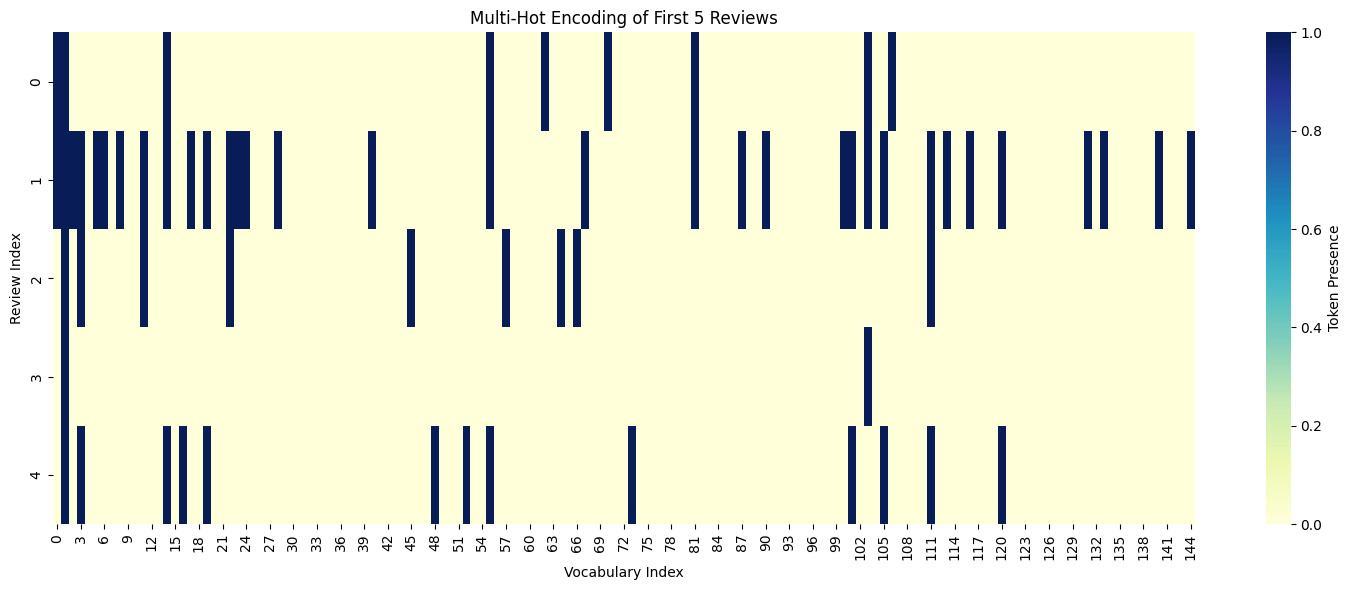

Normalized Log Loss Examples:

ypred=0.8, ytrue=1: Loss = 0.2231

High confidence correct prediction (80% sure, actually positive)
Low loss indicates a good prediction


ypred=0.2, ytrue=0: Loss = 0.2231

High confidence correct prediction (20% sure, actually negative)
Same low loss as first example


ypred=0.5, ytrue=1: Loss = 0.6931

Uncertain prediction (50/50 chance)
High loss penalizes lack of confidence
Shows the model is heavily punished for being unsure


ypred=0.1, ytrue=0: Loss = 0.1054

Low confidence correct prediction (10% sure, actually negative)
Lowest loss, rewarding being confidently correct

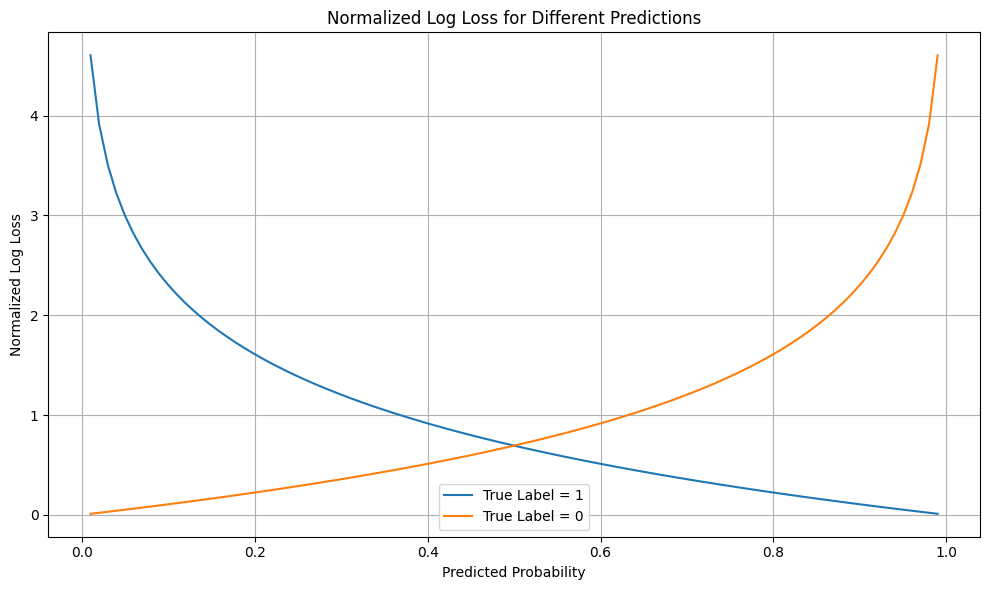

Key Insights:

Log loss rewards confident and correct predictions
Punishes uncertainty more than slightly incorrect predictions
Symmetrical punishment for being wrong in either direction
Demonstrates how machine learning models are evaluated`

In [1]:
import re
import pandas as pd

def tokenize(text):
    # Compile the regular expression pattern
    # This pattern handles:
    # 1. Contractions and possessives (with ≤ 3 letters after apostrophe)
    # 2. Tokens with letters and integers
    # 3. Tokens with dash in the middle
    # 4. Specific punctuation tokens (. ! ? , " ;)
    pattern = r'''(
        (?:[a-z0-9]+[-]?[a-z0-9]+)     # Tokens with optional dash (e.g., 24k, word-word)
        |[a-z0-9]+[''][a-z]{0,3}\b      # Contractions/possessives (e.g., can't, you're, Marvin's)
        |[a-z0-9]+                      # Other alphanumeric tokens
        |[.!?,";]                       # Specific punctuation tokens
    )'''

    # Compile the regex for efficiency
    compiled_pattern = re.compile(pattern, re.VERBOSE | re.IGNORECASE)

    # Tokenize the text
    return compiled_pattern.findall(text)

# Load the dataset
df = pd.read_csv('/content/amazon_books_Data.csv')

# Preprocess and tokenize the first 3 reviews
for i in range(3):
    # Lowercase the review body
    review_text = df.loc[i, 'review_body'].lower()

    # Tokenize the review
    tokens = tokenize(review_text)

    print(f"Review {i+1} Tokens:")
    print(tokens)
    print("\n")

Review 1 Tokens:
['"', 'i', 'love', 'it', 'and', 'so', 'does', 'my', 'students', '!', '"']


Review 2 Tokens:
['"', 'my', 'wife', 'and', 'i', 'ordered', '2', 'books', 'and', 'gave', 'them', 'as', 'presents', '.', '.', '.', 'one', 'to', 'a', 'friend', 's', 'daughter', 'and', 'the', 'other', 'to', 'our', 'grandson', '!', 'both', 'children', 'were', 'so', 'happy', 'with', 'the', 'story', ',', 'by', 'author', 'katrina', 'streza', ',', 'and', 'they', 'were', 'overjoyed', 'with', 'the', 'absolutely', 'adorable', 'artwork', ',', 'by', 'artist', 'michele', 'katz', ',', 'throughout', 'the', 'book', '!', 'we', 'highly', 'recommend', '34', ';', 'i', 'saw', 'a', 'friend', '34', ';', 'to', 'all', 'your', 'little', 'ones', '!', '!', '!', '"']


Review 3 Tokens:
['"', 'great', 'book', 'just', 'like', 'all', 'the', 'others', 'in', 'the', 'series', '.', '"']




In [2]:
import re
import pandas as pd
import numpy as np

def tokenize(text):
    pattern = r'''(
        (?:[a-z0-9]+[-]?[a-z0-9]+)
        |[a-z0-9]+[''][a-z]{0,3}\b
        |[a-z0-9]+
        |[.!?,";]
    )'''

    compiled_pattern = re.compile(pattern, re.VERBOSE | re.IGNORECASE)
    return compiled_pattern.findall(text.lower())

def lexicaScore(lexica, tokens):
    """
    Calculate relative frequencies of tokens in lexica dictionaries

    Args:
    - lexica: Dictionary of lexicon categories
      (e.g., {'positive': [...], 'negative': [...]})
    - tokens: List of tokens from a review

    Returns:
    - Dictionary of relative frequencies for each lexicon category
    """
    # Initialize category counts
    category_counts = {cat: 0 for cat in lexica.keys()}

    # Count occurrences of lexicon words
    for cat, words in lexica.items():
        category_counts[cat] = sum(1 for token in tokens if token in words)

    # Calculate total tokens (excluding punctuation)
    total_tokens = sum(1 for token in tokens if not re.match(r'^[.!?,";]$', token))

    # Calculate relative frequencies
    if total_tokens > 0:
        relative_frequencies = {
            cat: count / total_tokens
            for cat, count in category_counts.items()
        }
    else:
        relative_frequencies = {cat: 0 for cat in lexica.keys()}

    return relative_frequencies

def create_lexica():
    """
    Create lexicon dictionaries for sentiment analysis
    """
    positive_words = {
        'good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic',
        'awesome', 'love', 'best', 'perfect', 'brilliant', 'outstanding',
        'superb', 'delightful', 'enjoyable', 'pleasant', 'pleased', 'happy',
        'recommend', 'impressive', 'helpful', 'interesting', 'nice', 'well'
    }

    negative_words = {
        'bad', 'worst', 'terrible', 'horrible', 'awful', 'disappointing',
        'poor', 'useless', 'waste', 'hate', 'problem', 'issues', 'terrible',
        'boring', 'disappointed', 'frustrating', 'annoying', 'unhappy',
        'difficulty', 'difficult', 'worse', 'terrible', 'nightmare'
    }

    return {'positive': positive_words, 'negative': negative_words}

def predict_sentiment(lexica_scores, threshold=0.05):
    """
    Predict sentiment based on lexicon scores

    Args:
    - lexica_scores: Dictionary of relative frequencies
    - threshold: Minimum threshold for positive sentiment

    Returns:
    - Predicted sentiment (1 for positive, 0 for negative)
    """
    # If positive frequency is higher than threshold, predict positive
    return 1 if lexica_scores['positive'] > threshold else 0

def evaluate_predictions(df, lexica, threshold=0.05):
    """
    Evaluate sentiment predictions across the dataset

    Args:
    - df: DataFrame with reviews
    - lexica: Lexicon dictionaries
    - threshold: Sentiment prediction threshold

    Returns:
    - Accuracy of predictions
    - Detailed prediction results
    """
    results = []
    correct_predictions = 0

    # Convert star_rating to binary sentiment (1 for 4-5 stars, 0 for 1-3 stars)
    df['true_sentiment'] = (df['star_rating'] >= 4).astype(int)

    for index, row in df.iterrows():
        # Tokenize review
        tokens = tokenize(row['review_body'])

        # Calculate lexicon scores
        lexica_scores = lexicaScore(lexica, tokens)

        # Predict sentiment
        predicted_sentiment = predict_sentiment(lexica_scores, threshold)

        # Check if prediction is correct
        is_correct = predicted_sentiment == row['true_sentiment']
        if is_correct:
            correct_predictions += 1

        # Store result
        results.append({
            'index': index,
            'true_sentiment': row['true_sentiment'],
            'predicted_sentiment': predicted_sentiment,
            'positive_score': lexica_scores['positive'],
            'negative_score': lexica_scores['negative'],
            'correct': is_correct
        })

    # Calculate accuracy
    accuracy = correct_predictions / len(df)

    return accuracy, results

# Main execution
# Load the dataset
df = pd.read_csv('/content/amazon_books_Data.csv')

# Create lexica
lexica = create_lexica()

# Try different thresholds to find optimal performance
thresholds = [0.01, 0.03, 0.05, 0.07, 0.1]
best_accuracy = 0
best_threshold = 0

print("Threshold Exploration:")
for threshold in thresholds:
    accuracy, results = evaluate_predictions(df.head(50), lexica, threshold)
    print(f"Threshold {threshold}: Accuracy = {accuracy:.2%}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold} with Accuracy: {best_accuracy:.2%}")

# Detailed analysis of results with best threshold
accuracy, detailed_results = evaluate_predictions(df.head(50), lexica, best_threshold)

# Print detailed results
print("\nDetailed Prediction Results:")
results_df = pd.DataFrame(detailed_results)
print(results_df[['true_sentiment', 'predicted_sentiment', 'positive_score', 'negative_score', 'correct']])
print(f"\nTotal Correct Predictions: {results_df['correct'].sum()} out of {len(results_df)}")

Threshold Exploration:
Threshold 0.01: Accuracy = 44.00%
Threshold 0.03: Accuracy = 52.00%
Threshold 0.05: Accuracy = 62.00%
Threshold 0.07: Accuracy = 64.00%
Threshold 0.1: Accuracy = 70.00%

Best Threshold: 0.1 with Accuracy: 70.00%

Detailed Prediction Results:
    true_sentiment  predicted_sentiment  positive_score  negative_score  \
0                0                    1        0.125000        0.000000   
1                0                    0        0.030303        0.000000   
2                0                    0        0.100000        0.000000   
3                0                    0        0.000000        0.000000   
4                0                    0        0.000000        0.000000   
5                0                    0        0.014493        0.000000   
6                0                    0        0.000000        0.000000   
7                0                    1        0.333333        0.000000   
8                0                    1        0.200000     

<ipython-input-2-d455923a0c9d>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_sentiment'] = (df['star_rating'] >= 4).astype(int)
<ipython-input-2-d455923a0c9d>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true_sentiment'] = (df['star_rating'] >= 4).astype(int)
<ipython-input-2-d455923a0c9d>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Vocabulary Size: 145


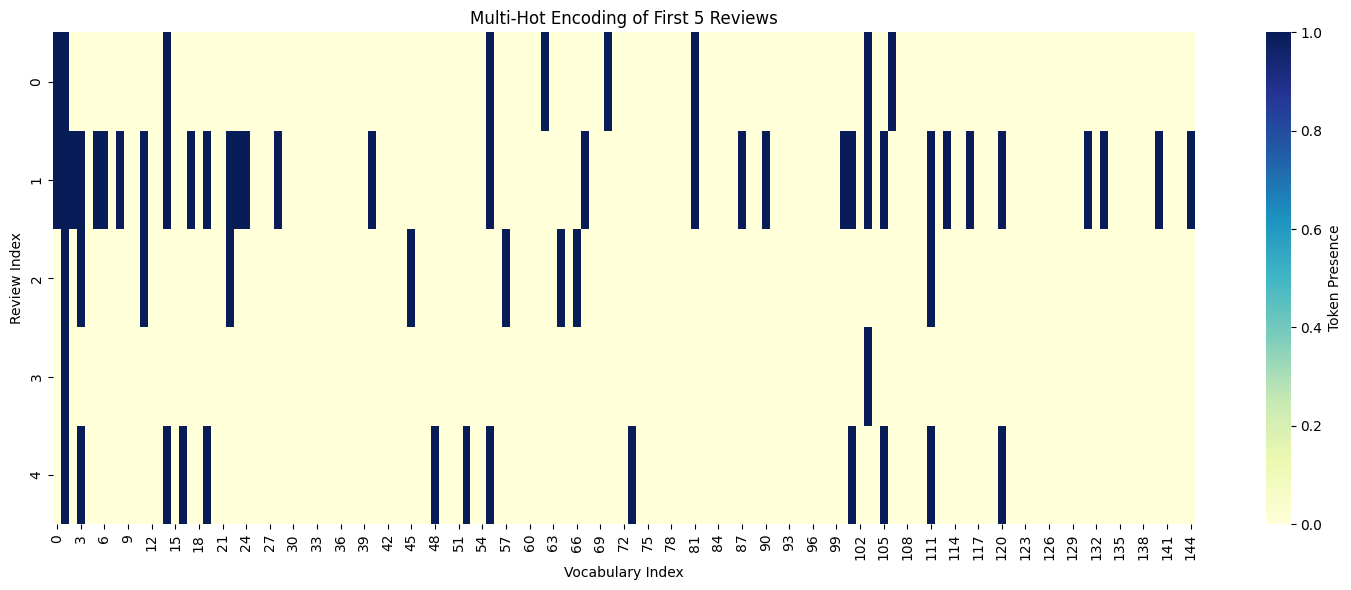


Normalized Log Loss Examples:
ypred=0.8, ytrue=1: Loss = 0.2231
ypred=0.2, ytrue=0: Loss = 0.2231
ypred=0.5, ytrue=1: Loss = 0.6931
ypred=0.1, ytrue=0: Loss = 0.1054


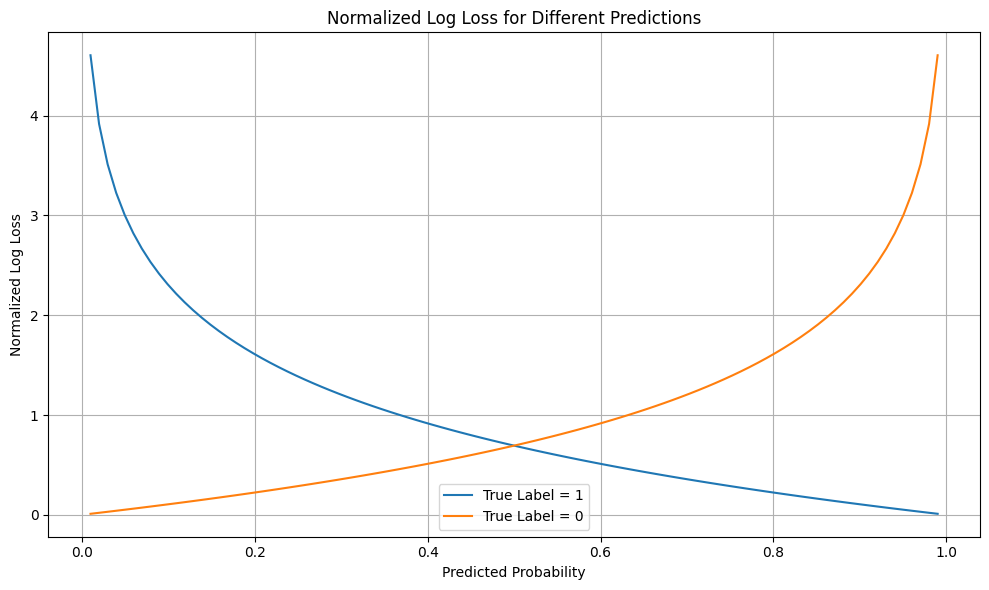

In [3]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def tokenize(text):
    pattern = r'''(
        (?:[a-z0-9]+[-]?[a-z0-9]+)
        |[a-z0-9]+[''][a-z]{0,3}\b
        |[a-z0-9]+
        |[.!?,";]
    )'''

    compiled_pattern = re.compile(pattern, re.VERBOSE | re.IGNORECASE)
    return compiled_pattern.findall(text.lower())

def prepare_vocabulary(df, min_frequency=5):
    """
    Prepare vocabulary from the dataset

    Args:
    - df: DataFrame containing reviews
    - min_frequency: Minimum number of times a token must appear to be included

    Returns:
    - Vocabulary dictionary mapping words to their index
    """
    # Tokenize all reviews
    all_tokens = []
    for review in df['review_body']:
        all_tokens.extend(tokenize(review))

    # Count token frequencies
    token_counts = Counter(all_tokens)

    # Filter tokens that appear more than min_frequency times
    vocab_tokens = [token for token, count in token_counts.items() if count >= min_frequency]

    # Create vocabulary dictionary (word to index mapping)
    vocab = {token: idx for idx, token in enumerate(sorted(vocab_tokens))}

    return vocab

def extractMultiHot(tokens, vocab):
    """
    Create multi-hot encoding for tokens

    Args:
    - tokens: List of tokens from a review
    - vocab: Vocabulary dictionary mapping words to indices

    Returns:
    - Multi-hot encoded vector
    """
    # Initialize zero vector with length of vocabulary
    multi_hot = [0] * len(vocab)

    # Mark indices for tokens in vocabulary
    for token in tokens:
        if token in vocab:
            multi_hot[vocab[token]] = 1

    return multi_hot

def normalizedLogLoss(ypred, ytrue):
    """
    Compute normalized log loss

    Args:
    - ypred: Predicted probability
    - ytrue: True label (0 or 1)

    Returns:
    - Normalized log loss value
    """
    # Ensure ypred is within (0, 1) to avoid log(0)
    epsilon = 1e-15
    ypred = np.clip(ypred, epsilon, 1 - epsilon)

    # Compute log loss
    log_loss = -(ytrue * np.log(ypred) + (1 - ytrue) * np.log(1 - ypred))

    return log_loss

# Load the dataset
df = pd.read_csv('/content/amazon_books_Data.csv')

# Prepare vocabulary
vocab = prepare_vocabulary(df)

# Demonstrate multi-hot encoding for first few reviews
print("Vocabulary Size:", len(vocab))

# Example multi-hot encoding
multi_hot_examples = []
for i in range(min(5, len(df))):
    tokens = tokenize(df.loc[i, 'review_body'])
    multi_hot = extractMultiHot(tokens, vocab)
    multi_hot_examples.append(multi_hot)

# Visualize multi-hot encodings
plt.figure(figsize=(15, 6))
sns.heatmap(multi_hot_examples, cmap='YlGnBu', cbar_kws={'label': 'Token Presence'})
plt.title('Multi-Hot Encoding of First 5 Reviews')
plt.xlabel('Vocabulary Index')
plt.ylabel('Review Index')
plt.tight_layout()
plt.show()

# Demonstrate normalized log loss
print("\nNormalized Log Loss Examples:")
examples = [
    (0.8, 1),   # High probability for positive class
    (0.2, 0),   # Low probability for negative class
    (0.5, 1),   # Uncertain prediction for positive class
    (0.1, 0)    # Low probability for negative class
]

for ypred, ytrue in examples:
    loss = normalizedLogLoss(ypred, ytrue)
    print(f"ypred={ypred}, ytrue={ytrue}: Loss = {loss:.4f}")

# Visualization of log loss for different predictions
ypreds = np.linspace(0.01, 0.99, 100)
losses_true_1 = [normalizedLogLoss(pred, 1) for pred in ypreds]
losses_true_0 = [normalizedLogLoss(pred, 0) for pred in ypreds]

plt.figure(figsize=(10, 6))
plt.plot(ypreds, losses_true_1, label='True Label = 1')
plt.plot(ypreds, losses_true_0, label='True Label = 0')
plt.title('Normalized Log Loss for Different Predictions')
plt.xlabel('Predicted Probability')
plt.ylabel('Normalized Log Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()